In [1]:
import pathlib
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
from utils import scatter_plot
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
dir = dict(output = pathlib.Path("./Output"))

# For plot customisation
sns.set_context('notebook')
sns.set_style('darkgrid')
plt.rc('axes', linewidth=1)
plt.rc('axes', edgecolor='k')
plt.rc('figure', dpi=100)
palette = sns.color_palette('deep')

In [3]:
xt = np.load(dir['output'] / 'xt.npy')


## Construct the test dataset

In [4]:
from Model.lorenz96_cubic import l96cb

Nx = 40
dt = 0.05
F = 8
diffusion = 0.025
friction = 1.0
tmodel = l96cb(Nx, dt, F, diffusion, friction)

In [5]:
Nt_test = 10000
Nx = xt.shape[1]
xtest = np.zeros((Nt_test, Nx))
xtest[0] = xt[-1]
for t in trange(1, Nt_test, desc='test model integration'):
    xtest[t] = xtest[t-1] + tmodel(xtest[t-1])

test model integration:   0%|          | 0/9999 [00:00<?, ?it/s]

In [6]:
# Reshape to have an ensemble
Nt_forecast = 200
Xtest = xtest.reshape(-1, Nt_forecast, Nx)

## Construct the hybrid model

In [7]:
learning = 'analysis'
if learning=='analysis':
    name = 'damodel'
else:
    name = 'true_model'
print(name)

damodel


In [8]:
import pickle
from tensorflow.keras.models import load_model
from Model.lorenz96 import l96
class l96hybrid(l96):
    def __init__(self, saved_model, **kwargs):
        super().__init__(**kwargs)
        self.saved_model = saved_model
        fnn = f'{self.saved_model}_nn'
        scalerx =  f'{self.saved_model}_scalerx'
        scalery =  f'{self.saved_model}_scalery'
        self.scaler_x = pickle.load(open(scalerx, 'rb'))
        self.scaler_y = pickle.load(open(scalery, 'rb'))
        self.nn = load_model(fnn)
    def __call__(self, q):
        dq_phi = super().__call__(q)
        #dq_nn =  self.scaler_y.inverse_transform(self.nn.predict(self.scaler_x.transform(q), verbose=0).squeeze())
        dq_nn =  self.scaler_y.inverse_transform(self.nn(self.scaler_x.transform(q)).numpy().squeeze())
        return dq_phi + dq_nn

2022-12-19 12:14:35.343030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
saved_model = dir['output'] / name

In [10]:
Nx = 40
dt = 0.05
F = 8
phi = l96(Nx, dt, F)
hyb_model = l96hybrid(Nx=Nx, dt=dt, F=F, saved_model=saved_model)

2022-12-19 12:14:39.989253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Run hybrid and physical model

In [11]:
xphi = np.zeros_like(Xtest)
xphi[:,0] = Xtest[:,0]
for t in trange(1, Nt_forecast, desc='proxy model integration'):
    xphi[:,t] = xphi[:,t-1] + phi(xphi[:,t-1])

proxy model integration:   0%|          | 0/199 [00:00<?, ?it/s]

In [12]:
xhyb = np.zeros_like(Xtest)
xhyb[:,0] = Xtest[:,0]
for t in trange(1, Nt_forecast, desc='proxy model integration'):
    xhyb[:,t] = xhyb[:,t-1] + hyb_model(xhyb[:,t-1])

proxy model integration:   0%|          | 0/199 [00:00<?, ?it/s]

## Plot scores

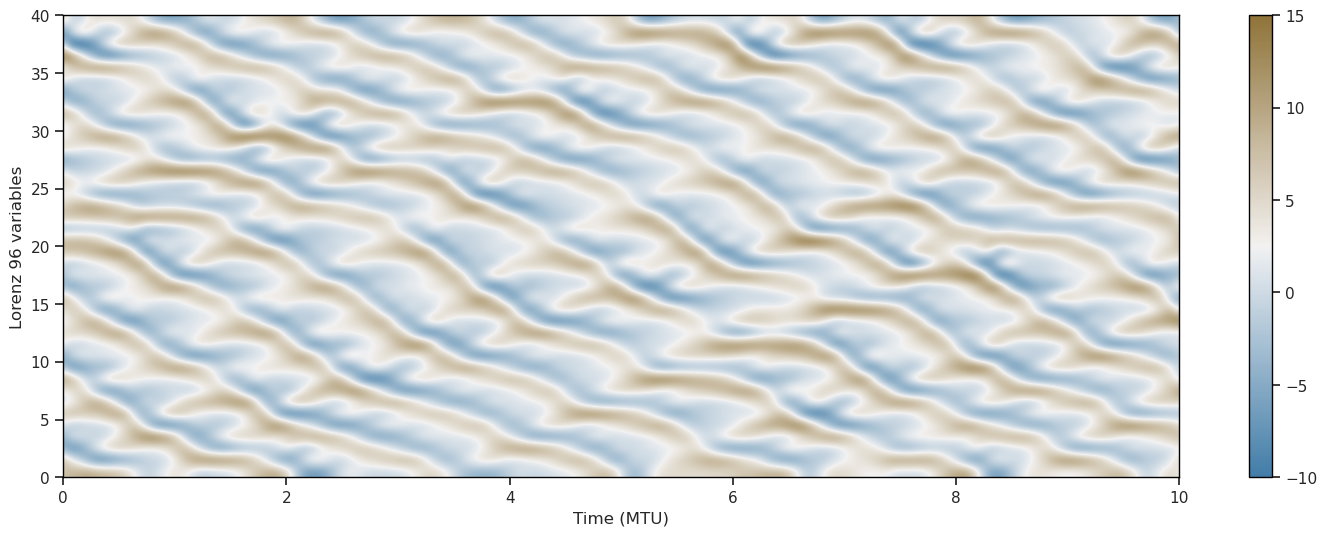

In [13]:
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(Xtest[0].T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*Xtest[0].shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('Lorenz 96 variables')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

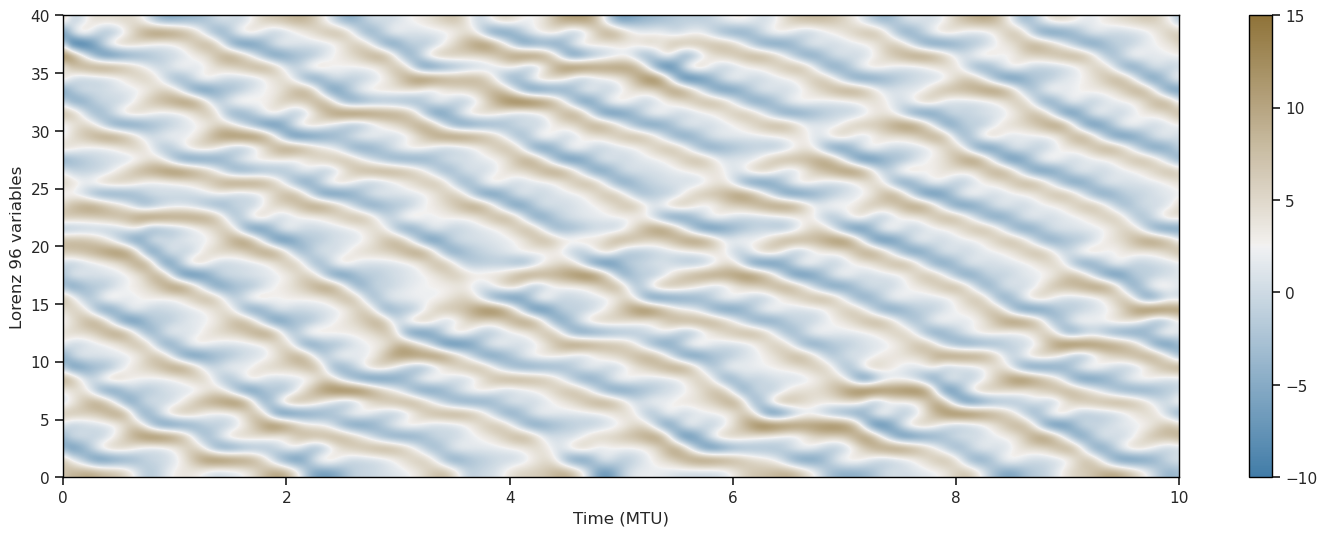

In [14]:
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(xhyb[0].T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*xhyb[0].shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('Lorenz 96 variables')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

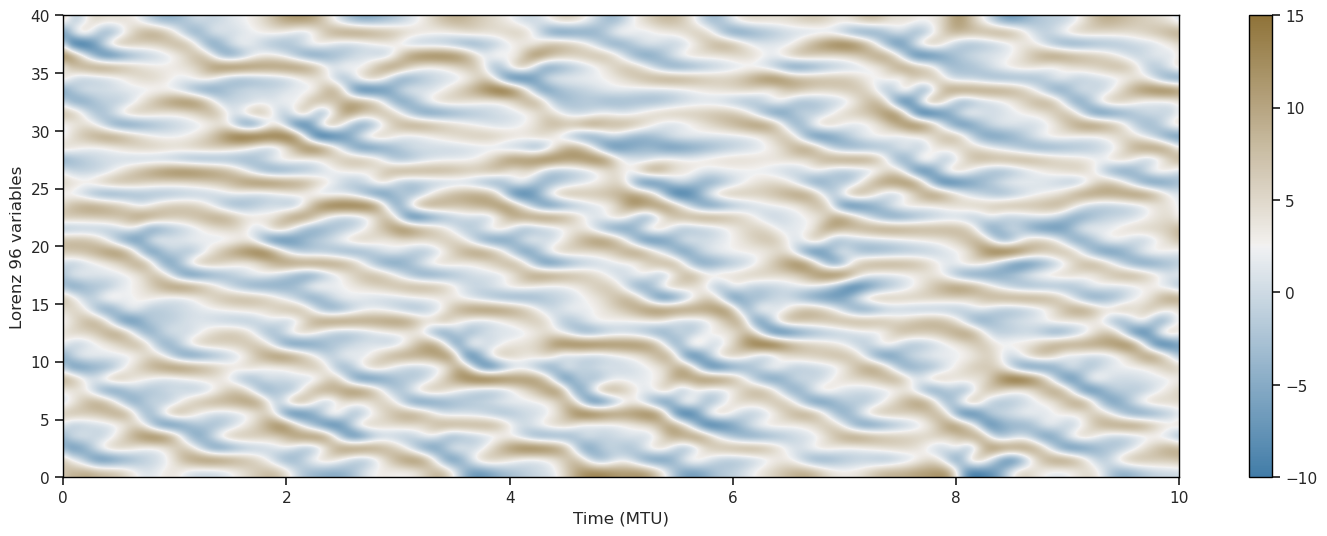

In [15]:
fig = plt.figure(figsize=(18, 6))
plt.grid(False)
im = plt.imshow(xphi[0].T, 
           aspect = 'auto',
           origin = 'lower',
           interpolation = 'spline36',
           cmap = sns.diverging_palette(240, 60, as_cmap=True),
           extent = [0, dt*xhyb[0].shape[0], 0, Nx],
           vmin = -10,
           vmax = 15)
plt.colorbar(im)
plt.xlabel('Time (MTU)')
plt.ylabel('Lorenz 96 variables')
plt.tick_params(direction='out', left=True, bottom=True)
plt.show()

In [16]:
rmse_phi = np.sqrt(np.mean(np.square(Xtest-xphi),axis=(0,2))/2)
rmse_hyb = np.sqrt(np.mean(np.square(Xtest-xhyb),axis=(0,2))/2)
mod_var = np.std(xtest)

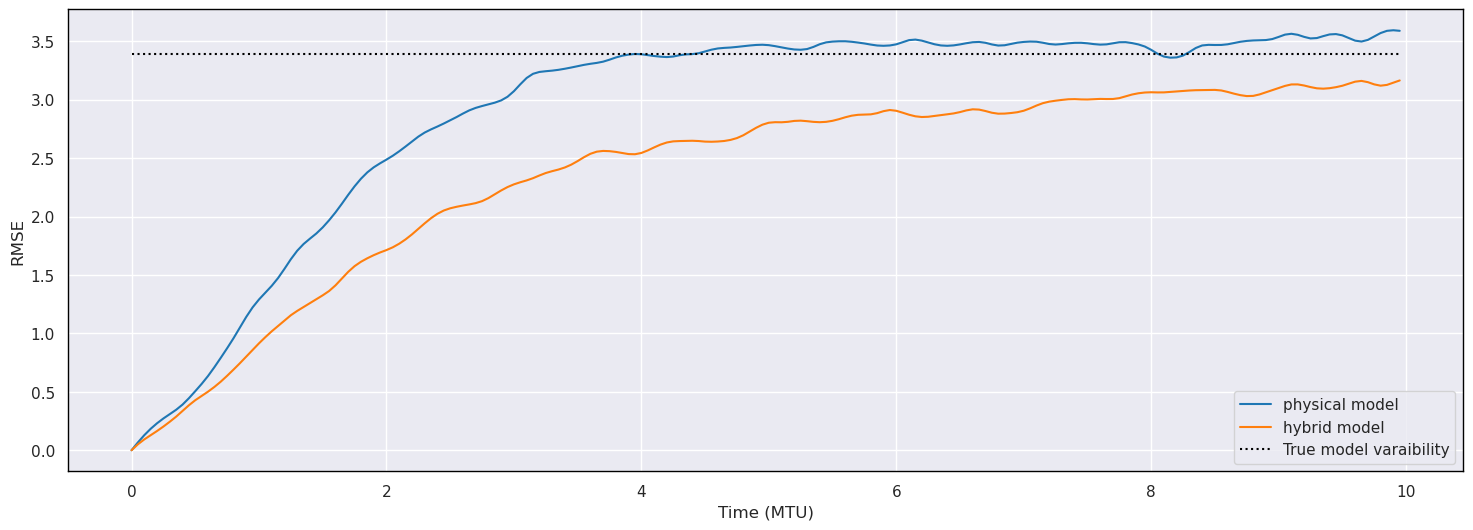

In [17]:
fig = plt.figure(figsize=(18, 6))
plt.plot(dt*np.arange(Nt_forecast), rmse_phi, label='physical model')
plt.plot(dt*np.arange(Nt_forecast), rmse_hyb, label='hybrid model')
plt.plot(dt*np.arange(Nt_forecast), mod_var*np.ones(Nt_forecast),':k', label='True model varaibility')
plt.legend()
plt.xlabel('Time (MTU)')
plt.ylabel('RMSE')
plt.savefig(f'Figures/rmse_{name}')
